# Making CMIP6 multimodel means

### Get the CMIP6 catalogue

In [1]:
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)["climate"]["cmip6_gcs"]
#list(cat)

### Pick out the historical temperature of the surface

In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import dask
from cmip6_preprocessing.preprocessing import (
    rename_cmip6, 
    promote_empty_dims, 
    broadcast_lonlat, 
    replace_x_y_nominal_lat_lon,
    combined_preprocessing,
)

def get_ts(experiment="historical", year_begin="1958", year_end="2014", xlim=[100, 290], ylim=[-30, 30]):
    query = dict(
        variable_id=["ts"],
        experiment_id=[experiment],# , "ssp585"],
        table_id=["Amon"],
        institution_id=["NCAR", "NOAA-GFDL", "MOHC", "NASA-GISS", "UA", "INM", "THU", "SNU", "E3SM-Project"],
    )
    subset = cat.search(**query)

    z_kwargs = {"consolidated": True, "decode_times": True}

    def wrapper(ds):
        ds = ds.copy()
        ds = rename_cmip6(ds)
        ds = promote_empty_dims(ds)
        ds = broadcast_lonlat(ds)
        ds = replace_x_y_nominal_lat_lon(ds)
        return ds

    # pass the preprocessing directly
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                            preprocess=wrapper)
        
    da_list = []; key_list = []
    
    first = True

    for key in dset_dict_proc:
        print(key)
        da = dset_dict_proc[key].ts.mean("member_id").sel(
            x=slice(xlim[0]-1, xlim[1]+1), y=slice(ylim[0]-1, ylim[1]+1), time=slice(year_begin, year_end)
        ).interp(x=list(range(xlim[0], xlim[1])), y=list(range(ylim[0], ylim[1])))  # .mean("time").plot()
        key_list.append(key)
        if first:
            times = da.time.values
        da = da.assign_coords(time=list(range(da.sizes["time"])))
        da_list.append(da)
    da = xr.concat(da_list, "model_center")
    da = da.assign_coords({"model_center": key_list, "time": times})
    
    return da

In [11]:
da_hist = get_ts(xlim=[0, 360], ylim=[-80, 80])
da_ssp585 = get_ts(experiment="ssp585", year_begin="2014", year_end="2017", xlim=[0, 360], ylim=[-80, 80])
combined_da_60 = xr.concat([da_hist.mean("model_center"), da_ssp585.mean("model_center")], "time")
combined_da_60.mean("time").to_netcdf("ts-CMIP6-clim60.nc")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn
CMIP.NCAR.CESM2-FV2.historical.Amon.gn
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.THU.CIESM.historical.Amon.gr
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr
CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr
CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid

ScenarioMIP.INM.INM-CM4-8.ssp585.Amon.gr1
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.Amon.gr1
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn
ScenarioMIP.THU.CIESM.ssp585.Amon.gr
ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
ScenarioMIP.MOHC.HadGEM3-GC31-MM.ssp585.Amon.gn
ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn
ScenarioMIP.UA.MCM-UA-1-0.ssp585.Amon.gn
ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn


In [ ]:
da_hist = get_ts()
da_ssp585 = get_ts(experiment="ssp585", year_begin="2014", year_end="2017")
combined_da_60 = xr.concat([da_hist.mean("model_center"), da_ssp585.mean("model_center")], "time")

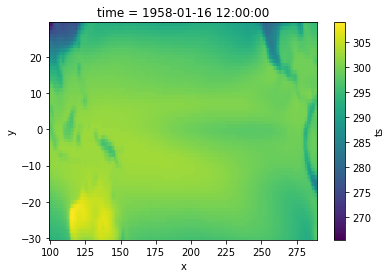

In [4]:
combined_da_60.isel(time=0).plot()

In [6]:
combined_da_60.isel(time=0).to_netcdf("test1958.nc")

In [8]:
combined_da_60.mean("time").to_netcdf("ts-CMIP6-clim60.nc")